# Data discovery and preparation for fast.ai 

This notebook is intented to understand each of the datasets available. So far, the tested datasets are:

* https://github.com/ieee8023/covid-chestxray-dataset
* https://www.kaggle.com/c/rsna-pneumonia-detection-challenge
* In house dataset from the Josep Trueta hospital, Girona, Spain (private-internal dataset). 


In [1]:
import pandas as pd
import numpy as np
import os, shutil
import matplotlib.pyplot as plt   
import matplotlib
import cv2
import pydicom as dicom
from skimage import color, io
from skimage.exposure import match_histograms

# Data discovery

## 1. Github repository

Open database of COVID-19 cases with chest X-ray or CT images that is being updated regularly with new cases published or scraped. Download the dataset from [here](https://github.com/ieee8023/covid-chestxray-dataset). Extract data from the repository and build classes. In particular, we are interested in `viral`, `bacteria` and `covid` classes. We only use `Posterior-Anterior` (PA) views.


In [2]:
GITHUB_DATA_PATH = '/home/sergivalverde/DATA/COVID/covid-chestxray-dataset/'
METADATA_PATH = os.path.join(GITHUB_DATA_PATH, 'metadata.csv')

df = pd.read_csv(METADATA_PATH)
PA = df['view']=='PA'

# COVID
gh_covid_patients = df['finding']=='COVID-19'

# bacteria
gh_bacteria_patients = df['finding'] == 'Chlamydophila'
gh_bacteria_patients |= df['finding'] == 'Klebsiella'
gh_bacteria_patients |= df['finding'] == 'Legionella'
gh_bacteria_patients |= df['finding'] == 'Streptococcus'

# viral 
gh_viral_patients = df['finding']=='SARS'

# fungal 
gh_fungal_bacteria = df['finding'] == 'Pneumocystis'

gh_covid=df[gh_covid_patients & PA]
gh_viral=df[gh_viral_patients & PA]
gh_bact=df[gh_bacteria_patients & PA]


gh_covid_files=[os.path.join('covid-chestxray-dataset', 'images', file) 
             for file in gh_covid['filename']]

gh_bact_files=[os.path.join('covid-chestxray-dataset', 'images', file) 
             for file in gh_bact['filename']]

gh_viral_files=[os.path.join('covid-chestxray-dataset', 'images', file) 
             for file in gh_viral['filename']]

gh_pneumonia_files = gh_bact_files + gh_viral_files

print('COVID cases:', len(gh_covid_files))
print('PNEUMONIA cases:', len(gh_pneumonia_files))


COVID cases: 97
PNEUMONIA cases: 28


## 2. Kaggle RSNA Dataset

Data from the [Kaggle](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge) challenge proposed to classify normal from different pneumonia types using chest x-rays. The dataset has to be downloaded from the same website after logging. Once downloaded, extract data from the repository and build a `pandas` dataset to process it further. 


In [4]:
# data paths and related CSV
KAGGLE_DATA_PATH = '/home/sergivalverde/DATA/COVID/rsna_pneumonia'
csv_all_path = os.path.join(KAGGLE_DATA_PATH, 'stage_2_detailed_class_info.csv')
csv_train_labels_path = os.path.join(KAGGLE_DATA_PATH, 'stage_2_train_labels.csv')

# load dataframes 
df_csv_all = pd.read_csv(os.path.join(KAGGLE_DATA_PATH, csv_all_path), nrows=None)
df_csv_labels = pd.read_csv(os.path.join(KAGGLE_DATA_PATH, csv_train_labels_path), nrows=None)

#filter normal and pneumonia cases
normal_cases = df_csv_all['class'] == 'Normal'
pneumonia_cases = df_csv_labels['Target'] == 1
df_kaggle_normal = df_csv_all[normal_cases]
df_kaggle_pneumonia = df_csv_all[pneumonia_cases]

# dicom files 
kaggle_pneumonia_files = [os.path.join(KAGGLE_DATA_PATH, 'stage_2_train_images', file + '.dcm') 
                         for file in df_kaggle_pneumonia['patientId']]

kaggle_normal_files = [os.path.join(KAGGLE_DATA_PATH, 'stage_2_train_images', file + '.dcm') 
                         for file in df_kaggle_normal['patientId']]

print('NORMAL cases', len(kaggle_normal_files))
print('PNEUMONIA cases', len(kaggle_pneumonia_files))


NORMAL cases 8851
PNEUMONIA cases 9555


# 3. Combine datasets for training / inference

Combine datasets before processing them. Basically adding each of the different datasets and splitting them between `training` and `testing`. We define the percentage of training / testing images to use with `PERC_TRAIN` variable.

In [6]:
PERC_TRAIN = 0.9

# GH dataset
p_index = int(len(gh_covid_files) * PERC_TRAIN)
gh_covid_files_train = gh_covid_files[:p_index]
gh_covid_files_test = gh_covid_files[p_index:]
gh_covid_labels_train = ['covid' for f in gh_covid_files_train]
gh_covid_labels_test = ['covid' for f in gh_covid_files_test]

p_index = int(len(gh_pneumonia_files) * PERC_TRAIN)
gh_pneumonia_files_train = gh_pneumonia_files[:p_index]
gh_pneumonia_files_test = gh_pneumonia_files[p_index:]
gh_pneumonia_labels_train = ['pneumonia' for f in gh_pneumonia_files_train]
gh_pneumonia_labels_test = ['pneumonia' for f in gh_pneumonia_files_test]

# KAGGLE RSNA images
p_index = int(len(kaggle_pneumonia_files) * PERC_TRAIN)
kaggle_pneumonia_files_train = kaggle_pneumonia_files[:p_index]
kaggle_pneumonia_files_test = kaggle_pneumonia_files[p_index:]
kaggle_pneumonia_labels_train = ['pneumonia' for f in kaggle_pneumonia_files_train]
kaggle_pneumonia_labels_test = ['pneumonia' for f in kaggle_pneumonia_files_test]

p_index = int(len(kaggle_normal_files) * PERC_TRAIN)
kaggle_normal_files_train = kaggle_normal_files[:p_index]
kaggle_normal_files_test = kaggle_normal_files[p_index:]
kaggle_normal_labels_train = ['normal' for f in kaggle_normal_files_train]
kaggle_normal_labels_test = ['normal' for f in kaggle_normal_files_test]

# set training / test dataset 

training_dataset = gh_covid_files_train + gh_pneumonia_files_train + kaggle_pneumonia_files_train + kaggle_normal_files_train
training_labels = gh_covid_labels_train + gh_pneumonia_labels_train + kaggle_pneumonia_labels_train + kaggle_normal_labels_train

test_dataset = gh_covid_files_test + gh_pneumonia_files_test + kaggle_pneumonia_files_test + kaggle_normal_files_test
test_labels = gh_covid_labels_test + gh_pneumonia_labels_test + kaggle_pneumonia_labels_test + kaggle_normal_labels_test

print('Training dataset:', len(training_dataset), len(training_labels))
print('Test dataset:', len(test_dataset), len(test_labels))

Training dataset: 16676 16676
Test dataset: 1855 1855


# 4. Data processing (may take a while)

Preprocess input images and store into a destination folder that will be used for training/testing the model. Define the destination folder `DESTINATION_FOLDER`. New folders for `train` and `test` will be created inside with images from `training_dataset` and `test_dataset`, respectively. 

Preprocessing steps:

* converting to 2D (forcing all the images to have 2 dimensions)
* ~histogram matching between the first image of the dataset used as `reference` and the rest of images~

## Training dataset

Process the training dataset and store a `Dataframe` with the path and label for each scan. This `Dataframe` will be used to select images during training using the `DataBunch` class in `fastai`. 

Training and testing data will be writen in `DESTINATON_PATH/train` and `DESTINATION_PATH/test` respectively. 

In [7]:
DESTINATION_PATH = 'data/COVIDx'

# some load/save and normalization functions
def load_case(input_file):
    _, ext = os.path.splitext(input_file)
    if ext == '.dcm':
        return dicom.dcmread(input_file).pixel_array
    else:
        return cv2.imread(input_file)

def convert_to_rgb(input_scan):
    if np.ndim(input_scan) == 2:
        input_scan = color.gray2rgb(input_scan)
    return input_scan


# check if the destination folder exists:
if os.path.exists(DESTINATION_PATH) is False:
    os.mkdir(DESTINATION_PATH)
if os.path.exists(os.path.join(DESTINATION_PATH, 'train')) is False:
    os.mkdir(os.path.join(DESTINATION_PATH, 'train'))

list_of_cases = []
for im, l in zip(training_dataset, training_labels):

    # extract scan information 
    _, scan_name = os.path.split(im)
    scan_id, _ = os.path.splitext(scan_name)
    # print('processing scan', scan_id, "class: ", l)
    
    # process scans before copying them into the destination folder
    scan = load_case(im)
    scan = convert_to_rgb(scan)
    
    # save the scan 
    dest_path = os.path.join(DESTINATION_PATH, 'train', scan_id + '.png')
    cv2.imwrite(dest_path, scan)
    
    # populate the dictionary
    list_of_cases.append({'name': dest_path, 'label': l})

In [8]:
train_df = pd.DataFrame(list_of_cases)
train_df.describe(include='all')
train_df.to_pickle('covidX_train.pkl')

## Testing dataset

Process the testing dataset and store a `Dataframe` with the path and label for each scan. This `Dataframe` will be used to select images during testing. 

In [10]:
if os.path.exists(os.path.join(DESTINATION_PATH, 'test')) is False:
    os.mkdir(os.path.join(DESTINATION_PATH, 'test'))

# ----------------
# test folder
# ----------------
list_of_cases = []
for im, l in zip(test_dataset, test_labels):

    # extract scan information 
    _, scan_name = os.path.split(im)
    scan_id, _ = os.path.splitext(scan_name)
    #print('processing scan', scan_id, "class: ", l)
    
    # process scans before copying them into the destination folder
    scan = load_case(im)
    scan = convert_to_rgb(scan)
    
    # save the scan 
    dest_path = os.path.join(DESTINATION_PATH, 'test', scan_id + '.png')
    cv2.imwrite(dest_path, scan)
    
    # populate the dictionary
    list_of_cases.append({'name': dest_path, 'label': l})

In [11]:
test_df = pd.DataFrame(list_of_cases)
test_df.describe(include='all')
test_df.to_pickle('covidX_test.pkl')

## Example of loading data in fast.ai

Once the data is stored in `DESTINATON_PATH/train` and `DESTINATION_PATH/test`, just define an `ImageDataBunch` and call labels from the dataframe `df_train`. 

TRAIN: 12507 VALIDATION: 4169


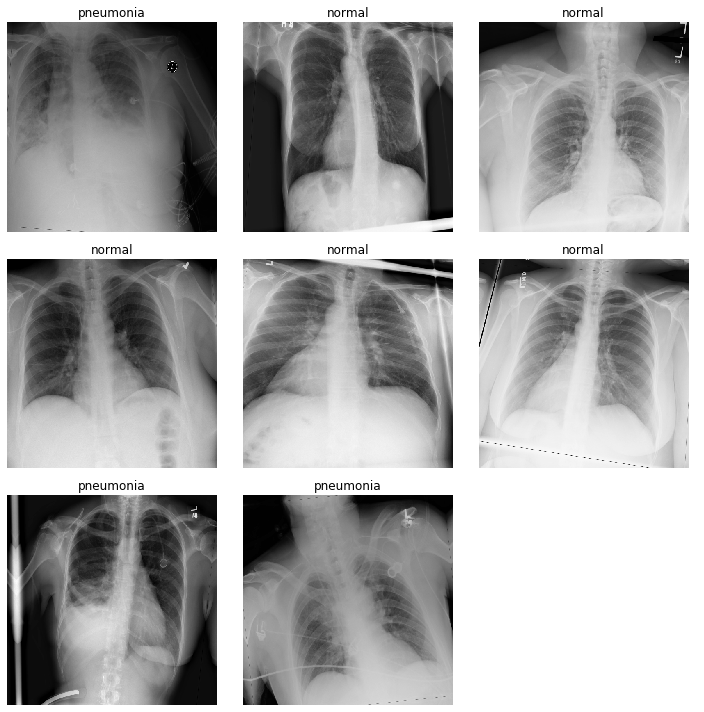

In [14]:
from fastai.vision import *

data = ImageDataBunch.from_df(path='.', 
                              df=train_df,
                              valid_pct=0.25,
                              test=None,
                              ds_tfms=get_transforms(), 
                              bs=8, 
                              size=512, 
                              num_workers=8).normalize(imagenet_stats)

#show size of our datasets
print("TRAIN:", len(data.train_ds),
      "VALIDATION:", len(data.valid_ds))

data.show_batch(rows=3, figsize=(10,10))